<a href="https://colab.research.google.com/github/cuauhtemocbe/Diplomado-Ciencia-Datos/blob/main/notebooks/Clasificaci%C3%B3n_Pok%C3%A9mons_Base.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Data Wrangling
import os
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Modeling
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Data Visualization
# import cufflinks as cf
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Configuración del notebook
# cf.go_offline()
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.FATAL)

# Librerías adicionales
import shutil
import os
from PIL import Image
from tqdm import tqdm
from IPython.display import clear_output

class CustomLogger(tf.keras.callbacks.Callback):
    def __init__(self):
        super(CustomLogger, self).__init__()
        self.epoch_logs = []
        self.best_val_accuracy = 0  # Variable para almacenar el mejor val_accuracy
        self.best_epoch_log = {}     # Variable para almacenar los logs del mejor epoch
        self.best_epoch_index = 0    # Variable para almacenar el índice del mejor epoch

    def on_epoch_end(self, epoch, logs=None):
        # Guardar los logs de la época actual
        self.epoch_logs.append(logs)

        # Actualizar el mejor val_accuracy y el log correspondiente
        current_val_accuracy = logs.get("val_accuracy")
        if current_val_accuracy > self.best_val_accuracy:
            self.best_val_accuracy = current_val_accuracy
            self.best_epoch_log = logs.copy()  # Almacenar el log del mejor epoch
            self.best_epoch_index = epoch

        # Mantener solo las últimas 5 épocas
        if len(self.epoch_logs) > 5:
            self.epoch_logs.pop(0)

        # Limpiar la salida anterior
        clear_output(wait=True)

        # Mostrar las últimas 5 épocas
        print("\nÚltimas 5 épocas:")
        for i, log in enumerate(self.epoch_logs):
            epoch_num = epoch - len(self.epoch_logs) + i + 1
            rounded_log = {k: round(v, 4) for k, v in log.items()}  # Redondear los valores de logs
            print(f"Epoch {epoch_num}: {rounded_log}")

        # Mostrar el log de la mejor época
        rounded_best_log = {k: round(v, 4) for k, v in self.best_epoch_log.items()}  # Redondear el mejor log
        print("\nMejor Epoch:")
        print(f"Epoch {self.best_epoch_index} (val_accuracy={round(self.best_val_accuracy, 4):.4f}): {rounded_best_log}")


def copy_images(data, folder_name, images_dir):
    for _, row in data.iterrows():
        name = row["Name"]
        type1 = row["Type1"]

        # Construir las rutas de los archivos de origen para ambos formatos
        png_source_file = os.path.join(images_dir, f"{name}.png")
        jpg_source_file = os.path.join(images_dir, f"{name}.jpg")

        # Construir la ruta del archivo de destino
        dest_dir = os.path.join(folder_name, type1)
        os.makedirs(folder_name, exist_ok=True)
        os.makedirs(os.path.join(folder_name, type1), exist_ok=True)

        # Copiar el archivo PNG si existe
        if os.path.exists(png_source_file):
            dest_file = os.path.join(dest_dir, f"{name}.png")
            shutil.copy(png_source_file, dest_file)
        # Copiar el archivo JPG si existe
        elif os.path.exists(jpg_source_file):
            dest_file = os.path.join(dest_dir, f"{name}.jpg")
            shutil.copy(jpg_source_file, dest_file)
        else:
            print(f"El archivo {name} no existe en formato PNG o JPG.")


def display_sample_images(df, image_folder, num_images=16, rows=4, cols=4):
    """"""
    # Selecciona un muestreo aleatorio de imágenes
    sampled_images = df["Name"].sample(n=num_images).tolist()

    # Configura el tamaño de la figura
    fig = plt.gcf()
    fig.set_size_inches(24, 24)
    plt.figure(figsize=(12, 10), dpi=80)

    # Mostrar las imágenes
    for i, img_name in enumerate(sampled_images):
        # Probar ambas extensiones
        img_paths = [
            os.path.join(image_folder, f"{img_name}.jpg"),
            os.path.join(image_folder, f"{img_name}.png")
        ]

        img_path = None
        for path in img_paths:
            if os.path.exists(path):
                img_path = path
                break

        # Si se encuentra la imagen, se muestra
        if img_path:
            sp = plt.subplot(rows, cols, i + 1)
            sp.axis("Off")
            img = mpimg.imread(img_path)
            sp.set_title(os.path.basename(img_path), fontsize=6)
            plt.imshow(img)
        else:
            print(f"No se encontró la imagen para: {img_name}")

    plt.tight_layout()
    plt.show()


from PIL import Image

def remove_transparency_add_background(image, background_color=(255, 255, 255)):
    """
    Elimina la transparencia de una imagen y añade un fondo de color.

    Args:
    - image (PIL.Image): La imagen que se va a procesar.
    - background_color (tuple): El color del fondo (RGB) a añadir donde la imagen sea transparente (por defecto: blanco).

    Returns:
    - PIL.Image: La imagen con el fondo aplicado y sin transparencia.
    """
    # Verifica si la imagen tiene un canal alfa (RGBA) o si está en modo "P"
    if image.mode in ("P"):
        image = image.convert("RGBA")

    if image.mode == "RGBA":
        # Crear una imagen de fondo con el color especificado (fondo blanco por defecto) y en modo RGBA
        background = Image.new("RGBA", image.size, background_color + (255,))
        # Combinar la imagen con el fondo
        image_rgb = Image.alpha_composite(background, image)
        image_rgb = image_rgb.convert("RGB")  # Convertir a RGB para eliminar el canal alfa
        return image_rgb
    else:
        # Si la imagen no tiene transparencia (RGB), simplemente la retornamos como está
        return image.convert("RGB")

from PIL import Image, ImageFilter, ImageOps

def detect_edges(image):
    # Convertir a escala de grises
    gray = image.convert('L')

    # Detectar bordes usando el filtro FIND_EDGES de PIL
    edges = gray.filter(ImageFilter.FIND_EDGES)

    # Convertir los bordes a una máscara
    mask = ImageOps.colorize(edges, black="black", white="white")

    # Resaltar los bordes en la imagen original
    highlighted_edges = Image.blend(image, mask.convert('RGB'), alpha=0.5)

    return highlighted_edges


def process_images(input_folder, output_folder):
    # Crear la carpeta de salida si no existe
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    files = [f for f in os.listdir(input_folder) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

    for filename in tqdm(files, desc="Procesando imágenes"):
        image_path = os.path.join(input_folder, filename)
        output_path = os.path.join(output_folder, filename)

        try:
            image = Image.open(image_path)
            processed_image = remove_transparency_add_background(image)
            highlighted_edges = detect_edges(processed_image)
            highlighted_edges.save(output_path)
        except Exception as e:
            print(f"Error al procesar {filename}: {e}")

## Preparación de las carpetas

In [ ]:
!rm -rf Pokémons
!rm -f pokemons.zip && wget https://github.com/cuauhtemocbe/Diplomado-Ciencia-Datos/blob/main/data/Pok%C3%A9mons.zip?raw=true -O pokemons.zip
!unzip pokemons.zip > /dev/null

--2024-10-11 02:10:47--  https://github.com/cuauhtemocbe/Diplomado-Ciencia-Datos/blob/main/data/Pok%C3%A9mons.zip?raw=true
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/cuauhtemocbe/Diplomado-Ciencia-Datos/raw/refs/heads/main/data/Pok%C3%A9mons.zip [following]
--2024-10-11 02:10:47--  https://github.com/cuauhtemocbe/Diplomado-Ciencia-Datos/raw/refs/heads/main/data/Pok%C3%A9mons.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/cuauhtemocbe/Diplomado-Ciencia-Datos/refs/heads/main/data/Pok%C3%A9mons.zip [following]
--2024-10-11 02:10:47--  https://raw.githubusercontent.com/cuauhtemocbe/Diplomado-Ciencia-Datos/refs/heads/main/data/Pok%C3%A9mons.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.13

## Estableciendo las rutas

In [ ]:
# Main
main_dir = "Pokémons/dataset"
# Metadata
metadata_dir = os.path.join(main_dir, "pokemon.csv")
# Imágenes
images_dir = os.path.join(main_dir, "images")
images_processed_dir = os.path.join(main_dir, "images_processed")
# Train, Validation, Test
train_dir = os.path.join(main_dir, "train")
validation_dir = os.path.join(main_dir, "validation")
test_dir = os.path.join(main_dir, "test")

## Manejo de las transparencias

In [ ]:
process_images(images_dir, images_processed_dir)

Procesando imágenes: 100%|██████████| 809/809 [00:01<00:00, 464.19it/s]


## Análisis de la metadata

In [ ]:
df = pd.read_csv(metadata_dir)
print(f"Tamaño del DataFrame: {df.shape}")
df.head()

Tamaño del DataFrame: (809, 3)


,Name,Type1,Type2
0,bulbasaur,Grass,Poison
1,ivysaur,Grass,Poison
2,venusaur,Grass,Poison
3,charmander,Fire,NaN
4,charmeleon,Fire,NaN


In [ ]:
count_df = df.value_counts("Type1").reset_index()
count_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
Type1,Water,Normal,Grass,Bug,Psychic,Fire,Rock,Electric,Poison,Ground,Dark,Fighting,Dragon,Ghost,Steel,Ice,Fairy,Flying
count,114,105,78,72,53,53,46,40,34,32,29,29,27,27,26,23,18,3


**Nota:** Hay pocos registros para Fairy y Flying

In [ ]:
threshold = 50
types_with_few_samples = count_df[count_df["count"] < threshold]["Type1"].to_list()
types_with_few_samples

['Rock',
 'Electric',
 'Poison',
 'Ground',
 'Dark',
 'Fighting',
 'Dragon',
 'Ghost',
 'Steel',
 'Ice',
 'Fairy',
 'Flying']

In [ ]:
# # Agregando más datos para Fairy y Flying
n_samples = 50
over_sampled_df = pd.DataFrame()
for pokemon_type in types_with_few_samples:
  tmp_df = df[df["Type2"] == pokemon_type]
  size = min(n_samples, len(tmp_df))
  tmp_df = tmp_df.sample(n=size, random_state=42)
  tmp_df.loc[:, "Type1"] = tmp_df["Type2"]

  if over_sampled_df.empty:
        over_sampled_df = tmp_df
  else:
        over_sampled_df = pd.concat([over_sampled_df, tmp_df])

over_sampled_df = pd.concat([df, over_sampled_df]).reset_index(drop=True)

print(f"Tamaño del DataFrame: {over_sampled_df.shape}")

# Mostrando tipos de pokémon con pocos datos, con un aumento
# de muestras
over_sampled_df[over_sampled_df["Type1"].isin(types_with_few_samples)].value_counts("Type1")

Tamaño del DataFrame: (1084, 3)


,count
Type1,
Poison,66
Ground,64
Rock,60
Fighting,54
Flying,53
Steel,49
Electric,48
Fairy,47
Dark,46


In [ ]:
# df1 = df[["Name", "Type1"]]
# df2 = df[["Name", "Type2"]].dropna()

# df = pd.concat([df1, df2.rename(columns={"Type2": "Type1"})], ignore_index=True)

# print(df.shape)
# df.head()

## Train, Validation & Test

In [ ]:
new_df = over_sampled_df[over_sampled_df["Type1"].isin(over_sampled_df.value_counts("Type1").reset_index().Type1.head(10).to_list())]
new_df.shape

(719, 3)

In [ ]:
from re import X
from sklearn.model_selection import train_test_split

# Dividir el DataFrame en train y un conjunto temporal (test + validation)
train_df, temp_df = train_test_split(
    over_sampled_df, test_size=0.3, random_state=42, stratify=over_sampled_df["Type1"]
)

# Dividir el conjunto temporal en test y validation
test_df, validation_df = train_test_split(
    temp_df, test_size=0.5, random_state=42, stratify=temp_df["Type1"]
)

**Tamaño de los conjuntos de datos**

In [ ]:
print(f"Tamaño del conjunto de entrenamiento: {len(train_df)}")
print(f"Tamaño del conjunto de validación: {len(validation_df)}")
print(f"Tamaño del conjunto de prueba: {len(test_df)}")

Tamaño del conjunto de entrenamiento: 758
Tamaño del conjunto de validación: 163
Tamaño del conjunto de prueba: 163


## Organizando imágenes en train, validation y test

In [ ]:
!rm -rf {train_dir} {validation_dir} {test_dir}

In [ ]:
copy_images(train_df, train_dir, images_processed_dir)
copy_images(test_df, test_dir, images_processed_dir)
copy_images(validation_df, validation_dir, images_processed_dir)

## Visualización de pokémons

<Figure size 2400x2400 with 0 Axes>

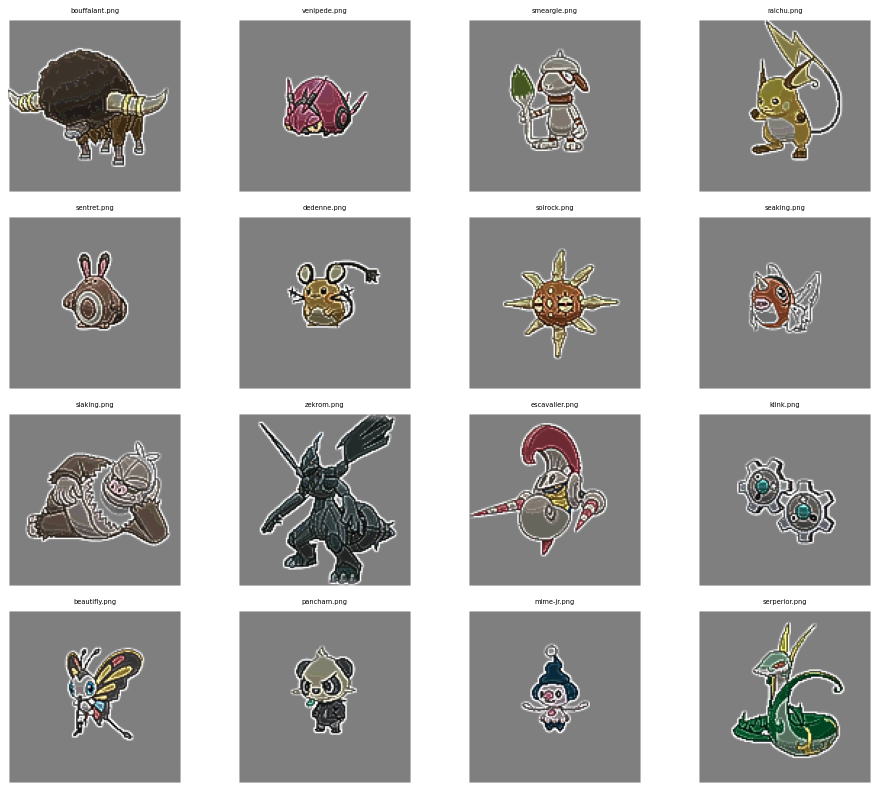

In [ ]:
display_sample_images(df, images_processed_dir, num_images=16, rows=4, cols=4)

## Modelación

#### Generadores

In [ ]:
dgen_train = ImageDataGenerator(
    rescale=1./255,  # Normalización de las imágenes
    rotation_range=20,  # Rotación aleatoria
    width_shift_range=0.1,  # Desplazamiento horizontal
    height_shift_range=0.1,  # Desplazamiento vertical
    shear_range=0.1,  # Corte aleatorio
    zoom_range=0.1,  # Zoom aleatorio
    horizontal_flip=True,  # Volteo horizontal
    fill_mode="nearest"  # Modo de relleno
)

dgen = ImageDataGenerator(rescale=1./255)

In [ ]:
TARGET_SIZE = (240, 240)
BATCH_SIZE = 32
CLASS_MODE = "sparse"
CLASS_NUMBER = df["Type1"].nunique()

In [ ]:
train_generator = dgen_train.flow_from_directory(train_dir,
                                                 target_size=TARGET_SIZE,
                                                 batch_size=BATCH_SIZE,
                                                 class_mode=CLASS_MODE)

validation_generator = dgen.flow_from_directory(validation_dir,
                                                target_size=TARGET_SIZE,
                                                batch_size=BATCH_SIZE,
                                                class_mode=CLASS_MODE)

test_generator = dgen.flow_from_directory(test_dir,
                                          target_size=TARGET_SIZE,
                                          batch_size=BATCH_SIZE,
                                          class_mode=CLASS_MODE)

Found 758 images belonging to 18 classes.
Found 163 images belonging to 18 classes.
Found 163 images belonging to 18 classes.


### Modelo Base

- 3 capas convolucionales
- Dropout capa densa 0.5
- learning rate de 0.0001
- batch de 16

In [ ]:
# model = Sequential()

# model.add(Input(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)))
# # Capa convolucional 1
# model.add(Conv2D(32, (3, 3), activation="relu"))
# model.add(MaxPooling2D((2, 2)))

# # Capa convolucional 2
# model.add(Conv2D(64, (3, 3), activation="relu"))
# model.add(MaxPooling2D((2, 2)))

# # Capa convolucional 3
# model.add(Conv2D(128, (3, 3), activation="relu"))
# model.add(MaxPooling2D((2, 2)))

# # Aplanar la salida para la capa densa
# model.add(Flatten())

# # Capa densa
# model.add(Dense(128, activation="relu"))
# model.add(Dropout(0.5))

# # Capa de salida
# model.add(Dense(CLASS_NUMBER, activation="softmax"))

# # Crear el logger
# custom_logger = CustomLogger()

# model.compile(Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20)
# checkpoint = tf.keras.callbacks.ModelCheckpoint("models/model_{val_accuracy:.3f}.keras",
#                                                 save_best_only=True,
#                                                 save_weights_only=False,
#                                                 monitor="val_accuracy"
# )

# history = model.fit(train_generator,
#                     epochs=100,
#                     validation_data=validation_generator,
#                     callbacks=[early_stopping,checkpoint, custom_logger],
#                     verbose=0)

### Modelo 64 neuronas kernel 5
- Score en val de 0.34
- 5 capas convolucionales
- Con Dropout en capa densa
- Kernel de 5 en primer capa y segunda capa
- learning rate de 0.0001

In [ ]:
!rm -rf models

In [ ]:
model = Sequential()

# Capa de entrada
model.add(Input(shape=(TARGET_SIZE[0], TARGET_SIZE[1], 3)))
# Bloque convolucional 1
model.add(Conv2D(32, (5, 5), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
# Bloque convolucional 2
model.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.2))
# Bloque convolucional 3
model.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
# Bloque convolucional 4
model.add(Conv2D(256, (3, 3), activation="relu", padding="same"))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.3))
# Aplanar y agregar capas densas
model.add(Flatten())
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.5))

# Capa de salida
model.add(Dense(18, activation="softmax"))  # 18 categorías

custom_logger = CustomLogger()

model.compile(Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=20)
checkpoint = tf.keras.callbacks.ModelCheckpoint("models/model_{val_accuracy:.3f}.keras",
                                                save_best_only=True,
                                                save_weights_only=False,
                                                monitor="val_accuracy"
)

history = model.fit(train_generator,
                    epochs=100,
                    validation_data=validation_generator,
                    callbacks=[early_stopping,checkpoint, custom_logger],
                    verbose=0)


Últimas 5 épocas:
Epoch 95: {'accuracy': 0.3179, 'loss': 2.1753, 'val_accuracy': 0.184, 'val_loss': 2.7614}
Epoch 96: {'accuracy': 0.3113, 'loss': 2.1867, 'val_accuracy': 0.1779, 'val_loss': 2.7413}
Epoch 97: {'accuracy': 0.3153, 'loss': 2.175, 'val_accuracy': 0.2025, 'val_loss': 2.7423}
Epoch 98: {'accuracy': 0.3272, 'loss': 2.1319, 'val_accuracy': 0.2025, 'val_loss': 2.7681}
Epoch 99: {'accuracy': 0.3338, 'loss': 2.1451, 'val_accuracy': 0.1902, 'val_loss': 2.7203}

Mejor Epoch:
Epoch 80 (val_accuracy=0.2393): {'accuracy': 0.3021, 'loss': 2.2917, 'val_accuracy': 0.2393, 'val_loss': 2.6643}


## Revisando scores

In [ ]:
os.listdir("./models/")
max_acc = max([x.split(".")[-2] for x in os.listdir("./models/")])
print("Máximo score", max_acc)

Máximo score 239


In [ ]:
model = tf.keras.models.load_model(f'./models/model_0.{max_acc}.keras')

In [ ]:
test_loss, test_acc = model.evaluate(test_generator)
print('Test loss: {} Test Acc: {}'.format(test_loss, test_acc))

6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 117ms/step - accuracy: 0.1811 - loss: 2.6939
Test loss: 2.6376144886016846 Test Acc: 0.20245398581027985


## Para nuevas imagenes

In [ ]:
process_images("/content/new_pokemons",
               "/content/new_pokemons_processed")

Procesando imágenes: 100%|██████████| 10/10 [00:00<00:00, 12.41it/s]


In [ ]:
def predict_from_folder(model, folder_path, train_generator, target_size=(240, 240)):
  # Inicializamos una lista para guardar los resultados
  results = []

  # Diccionario para traducir las predicciones a nombres de clases
  classes_dict = {v: k for k, v in train_generator.class_indices.items()}

  # Iteramos sobre los archivos en la carpeta
  for filename in os.listdir(folder_path):
      if filename.endswith(('.jpg', '.jpeg', '.png')):  # Aseguramos que sean archivos de imagen
          file_path = os.path.join(folder_path, filename)

          # Cargamos la imagen y la preprocesamos
          test_image = load_img(file_path, target_size=target_size)
          image = img_to_array(test_image)
          image = np.expand_dims(image, axis=0)

          # Realizamos la predicción
          prediction = model.predict(image)
          predicted_class_idx = np.argmax(prediction, axis=1)[0]
          predicted_class = classes_dict[predicted_class_idx]
          predicted_prob = np.max(prediction)

          # Almacenamos el nombre del archivo, la clase predicha y la probabilidad
          results.append({
              'filename': filename,
              'predicted_class': predicted_class,
              'predicted_probability': predicted_prob
          })

  # Convertimos la lista de resultados a un DataFrame
  df_results = pd.DataFrame(results)

  return df_results

In [ ]:
resuls_df = predict_from_folder(
    model,
    "/content/new_pokemons_processed",
    train_generator
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


In [ ]:
resuls_df

,filename,predicted_class,predicted_probability
0,smoliv.png,Grass,1.0
1,charizard.png,Ice,1.0
2,sprigatito.png,Grass,1.0
3,dialga.png,Water,1.0
4,arceus.jpeg,Normal,1.0
5,quaxly.jpeg,Ground,1.0
6,charizard_y.png,Fire,1.0
7,gengar.png,Dark,1.0
8,fuecoco.png,Fire,1.0
9,palkia.png,Normal,1.0
